In [1]:
!pip install pystan==2.18.0.0
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.5 MB 604 kB/s 
  Created wheel for pystan: filename=pystan-2.18.0.0-cp38-cp38-linux_x86_64.whl size=56934896 sha256=5898b942cf7feaa7c0fbc08c18e5b96dde72852eea2e52ce30dad7eb5a76c3a1
  Stored in directory: /root/.cache/pip/wheels/c9/8d/a0/87147a86c11b867cb8e500fa47c9dd551624c336159f4a7b9f
Successfully built pystan
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 431 kB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6305646 sha256=e1008f6a14e1d683299b717feba6bb19fa198b75f362f73a19353f3606d6d4ec
  Stored in directory: /root/.cache/pip/wheels/d0/d2/ae/c579b7fd160999d35908f3c

In [2]:
#import packages for analysis
import pandas as pd
import numpy as np
import fbprophet
import matplotlib.pyplot as plt
%matplotlib inline
from fbprophet import Prophet

In [3]:
#import data into google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#read into a dataframe
df = pd.read_csv("/content/drive/MyDrive/price_data.csv")

In [5]:
df.shape

(743, 8)

In [6]:
#Get information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       743 non-null    object 
 1   interest   743 non-null    float64
 2   vacancy    743 non-null    float64
 3   cpi        743 non-null    float64
 4   price      743 non-null    int64  
 5   value      743 non-null    float64
 6   adj_price  743 non-null    float64
 7   adj_value  743 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 46.6+ KB


In [7]:
#Get description of the dataframe
df.describe()

,interest,vacancy,cpi,price,value,adj_price,adj_value
count,743.000000,743.000000,743.000000,743.000000,743.000000,743.000000,743.000000
mean,4.169744,7.887618,240.466335,227368.837147,250092.176570,93606.095136,103156.282570
std,0.808795,1.565285,19.570472,53526.166609,52099.242584,14902.351507,13771.936861
min,2.650000,5.600000,211.398000,145000.000000,178314.238600,63504.854840,78168.510140
25%,3.630000,6.800000,226.597000,185000.000000,212169.931650,82503.074180,94140.325790
50%,4.060000,7.300000,237.477000,215630.000000,233818.632000,91778.073170,101832.058100
75%,4.605000,9.400000,252.759500,259900.000000,283934.856600,102686.177100,112821.697600
max,6.630000,11.100000,296.761000,375000.000000,380135.564800,127001.974500,131111.258100


### Visualizing the Data

In [8]:
#Convert date column into a date format
df['Week'] = df["Date"]
df['Date'] = pd.to_datetime(df['Date'],format='%m/%d/%Y')
df.set_index("Date", inplace = True)

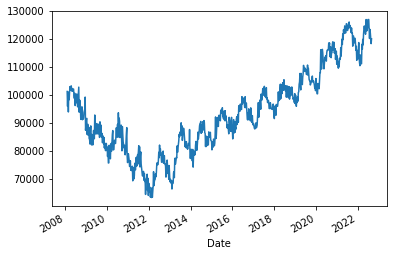

In [9]:
#Make plot of the median home sale Price 
df["adj_price"].plot()

In [10]:
#print columns of the dataframe
df.columns

Index(['interest', 'vacancy', 'cpi', 'price', 'value', 'adj_price',
       'adj_value', 'Week'],
      dtype='object')

### Forecasting using ARIMA

In [11]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [12]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [13]:
adfuller_test(df['adj_price'])

ADF Test Statistic : -1.2116139703425708
p-value : 0.668579827466446
#Lags Used : 8
Number of Observations Used : 734
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#### Differnecing

In [14]:
df['Seasonal First Difference']=df['adj_price']-df['adj_price'].shift(1)

In [15]:
df.head(10)

,interest,vacancy,cpi,price,value,adj_price,adj_value,Week,Seasonal First Difference
Date,,,,,,,,,
2008-02-02,5.68,10.1,212.174,215000,243109.3812,101331.92570,114580.1942,2/2/2008,NaN
2008-02-09,5.67,10.1,212.687,204250,243109.3812,96033.13790,114303.8273,2/9/2008,-5298.78780
2008-02-16,5.72,10.1,212.687,215000,243109.3812,101087.51360,114303.8273,2/16/2008,5054.37570
2008-02-23,6.04,10.1,212.687,200000,243109.3812,94034.89635,114303.8273,2/23/2008,-7052.61725
2008-03-01,6.24,10.1,212.687,215000,240739.0886,101087.51360,113189.3762,3/1/2008,7052.61725
2008-03-08,6.03,10.1,213.448,210000,240739.0886,98384.61827,112785.8254,3/8/2008,-2702.89533
2008-03-15,6.13,10.1,213.448,216000,240739.0886,101195.60740,112785.8254,3/15/2008,2810.98913
2008-03-22,5.87,10.1,213.448,220000,240739.0886,103069.60010,112785.8254,3/22/2008,1873.99270
2008-03-29,5.85,10.1,213.448,217150,240739.0886,101734.38030,112785.8254,3/29/2008,-1335.21980


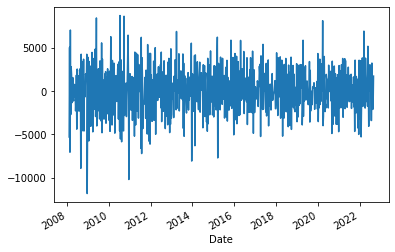

In [16]:
df['Seasonal First Difference'].plot()

In [17]:
## Again test dickey fuller test
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -8.34202179578284
p-value : 3.157376424087358e-13
#Lags Used : 7
Number of Observations Used : 734
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


#### Auto Regressive Model

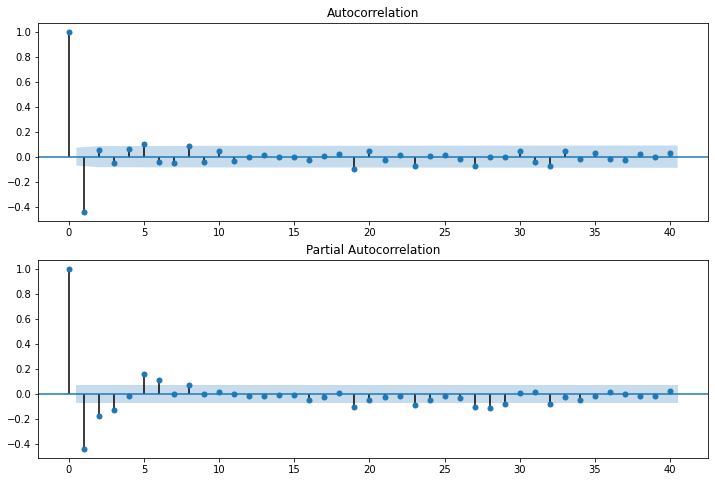

In [18]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[2:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[2:],lags=40,ax=ax2)

In [19]:
#run auto arima Model to select best model
!pip install pmdarima
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

model_arima = auto_arima(df['adj_price'],trace=True,suppress_warnings=True)
model_arima.summary()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 23.6 MB/s 
     |████████████████████████████████| 9.9 MB 52.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13787.131, Time=1.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13872.905, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13785.809, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13782.614, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13870.968, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13784.093, Time=1.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=13790.740, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13781.639, Time=3.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=13786.002, Time=1.77 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=13790.004, Time=0.62 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13792.584, Time=0.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=13784.946, Time=1.61 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=13788.427, Time=0.28 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 13.132 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  743
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -6885.820
Date:                Sat, 10 Dec 2022   AIC                          13781.639
Time:                        23:04:29   BIC                          13804.686
Sample:                             0   HQIC                         13790.524
                                - 743                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -51.3323    135.579     -0.379      0.705    -317.061     214.397
ar.L1         -0.8102      0.154     -5.264      0.000      -1.112      -0.509
ma.L1          0.5790      0.154      3.763      0.000       0.277       0.881
ma.L2         -0.1527      0.044     -3.440      0.001      -0.240      -0.066
sigma2      6.496e+06    1.9e-06   3.42e+12      0.000     6.5e+06     6.5e+06
===================================================================================
Ljung-Box (L1) (Q):                  41.66   Jarque-Bera (JB):                93.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.43e+31. Standard errors may be unstable.
"""

In [20]:
#For non-seasonal data
## taking p=1,d=1, q=2 for ARIMA model
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(df['adj_price'],order=(1,1,2))
model_fit=model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              adj_price   No. Observations:                  743
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -6890.213
Date:                Sat, 10 Dec 2022   AIC                          13788.427
Time:                        23:04:29   BIC                          13806.864
Sample:                             0   HQIC                         13795.535
                                - 743                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8222      0.168      4.885      0.000       0.492       1.152
ma.L1         -1.0694      0.171     -6.270      0.000      -1.404      -0.735
ma.L2          0.2280      0.040      5.721      0.000       0.150       0.306
sigma2      5.823e+06   2.79e-08   2.09e+14      0.000    5.82e+06    5.82e+06
===================================================================================
Ljung-Box (L1) (Q):                  40.28   Jarque-Bera (JB):               112.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.06e+30. Standard errors may be unstable.
"""

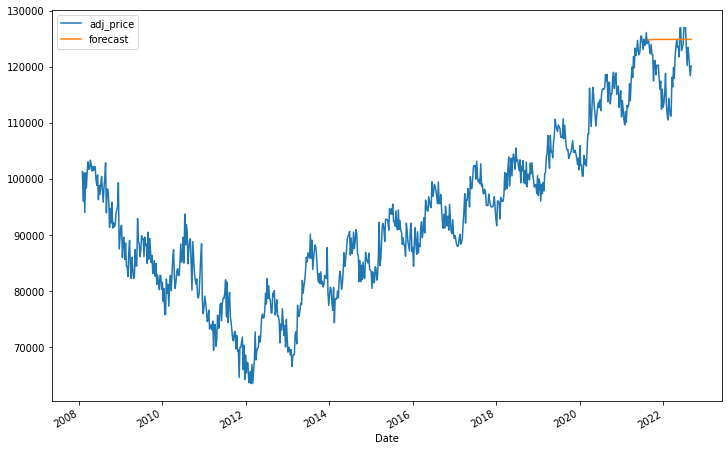

In [21]:
prediction = [None]*690
temp_list = model_fit.predict(start=691,end=743,dynamic=True).values.tolist()
flat_list = [item for item in temp_list]
prediction.extend(flat_list)
df['forecast'] = prediction
df[['adj_price','forecast']].plot(figsize=(12,8))

In [22]:
#split data into training and testing
test_size = 52

df_train = df[:-test_size]
df_test = df[-test_size:]

In [23]:
#Run and fit sarima model using arima(1,1,2)
model=sm.tsa.statespace.SARIMAX(df_train['adj_price'],order=(1, 1, 2),seasonal_order=(1,1,2,52))
results=model.fit()

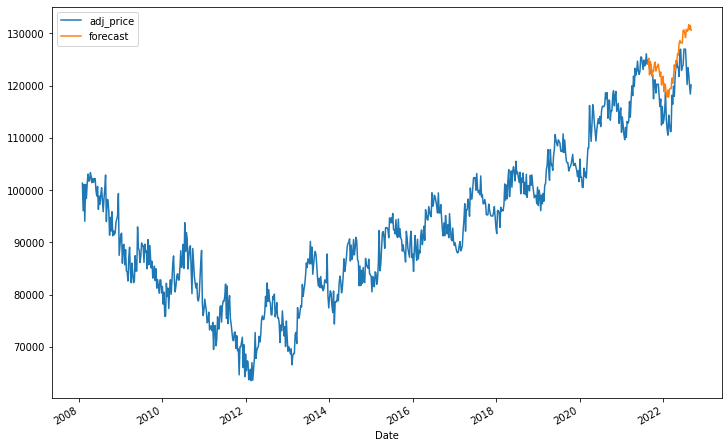

In [24]:
prediction = [None]*690
temp_list = results.predict(start=691,end=743,dynamic=True).values.tolist()
flat_list = [item for item in temp_list]
prediction.extend(flat_list)
df['forecast'] = prediction
df[['adj_price','forecast']].plot(figsize=(12,8))

#### Calculating RMSE & R2

In [25]:
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_percentage_error

In [26]:
arima_mse = metrics.mean_squared_error(df_test['adj_price'], df['forecast'].tail(52))
arima_rmse = np.sqrt(arima_mse)
arima_r2 = metrics.r2_score(df_test['adj_price'], df['forecast'].tail(52))
error = mean_absolute_percentage_error(df_test['adj_price'],df['forecast'].tail(52))

print("Results of ARIMA_metrics:")
print("RMSE:", arima_rmse)
print("R-Squared:", arima_r2)
print("MAPE:",error)

Results of ARIMA_metrics:
RMSE: 5636.607466401597
R-Squared: -0.46578920250353884
MAPE: 0.0398453086798733


### Forecasting using fbprophet

In [27]:
df_train = df_train[['Week','adj_price']]
df_train.head()

,Week,adj_price
Date,,
2008-02-02,2/2/2008,101331.92570
2008-02-09,2/9/2008,96033.13790
2008-02-16,2/16/2008,101087.51360
2008-02-23,2/23/2008,94034.89635
2008-03-01,3/1/2008,101087.51360


In [28]:
df_train['Week'] = pd.to_datetime(df_train['Week'],format='%m/%d/%Y')
df_train.columns = ['ds','y']
df_train.head(10)

,ds,y
Date,,
2008-02-02,2008-02-02,101331.92570
2008-02-09,2008-02-09,96033.13790
2008-02-16,2008-02-16,101087.51360
2008-02-23,2008-02-23,94034.89635
2008-03-01,2008-03-01,101087.51360
2008-03-08,2008-03-08,98384.61827
2008-03-15,2008-03-15,101195.60740
2008-03-22,2008-03-22,103069.60010
2008-03-29,2008-03-29,101734.38030


In [29]:
df_train.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [30]:
# Initialize the Model
model=Prophet()
# Fitting the Model
model.fit(df_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
model.component_modes

{'additive': ['yearly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [32]:
future_dates=model.make_future_dataframe(periods=52, freq="w")

In [33]:
future_dates

,ds
0,2008-02-02
1,2008-02-09
2,2008-02-16
3,2008-02-23
4,2008-03-01
...,...
738,2022-07-17
739,2022-07-24
740,2022-07-31
741,2022-08-07


In [34]:
future_dates.tail(52)

,ds
691,2021-08-22
692,2021-08-29
693,2021-09-05
694,2021-09-12
695,2021-09-19
696,2021-09-26
697,2021-10-03
698,2021-10-10
699,2021-10-17
700,2021-10-24


In [35]:
prediction=model.predict(future_dates)
prediction.head(52)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-02-02,102705.697598,94768.143049,100916.560072,102705.697598,102705.697598,-4870.591330,-4870.591330,-4870.591330,-4870.591330,-4870.591330,-4870.591330,0.0,0.0,0.0,97835.106268
1,2008-02-09,102465.811595,94499.335428,100439.188125,102465.811595,102465.811595,-4947.483475,-4947.483475,-4947.483475,-4947.483475,-4947.483475,-4947.483475,0.0,0.0,0.0,97518.328120
2,2008-02-16,102225.925592,94207.565845,100220.680268,102225.925592,102225.925592,-4953.343912,-4953.343912,-4953.343912,-4953.343912,-4953.343912,-4953.343912,0.0,0.0,0.0,97272.581681
3,2008-02-23,101986.039590,94078.355357,100138.239355,101986.039590,101986.039590,-4850.892738,-4850.892738,-4850.892738,-4850.892738,-4850.892738,-4850.892738,0.0,0.0,0.0,97135.146852
4,2008-03-01,101746.153587,94149.869137,100248.555429,101746.153587,101746.153587,-4443.994646,-4443.994646,-4443.994646,-4443.994646,-4443.994646,-4443.994646,0.0,0.0,0.0,97302.158941
5,2008-03-08,101506.267585,94949.560688,100923.595406,101506.267585,101506.267585,-3558.841234,-3558.841234,-3558.841234,-3558.841234,-3558.841234,-3558.841234,0.0,0.0,0.0,97947.426351
6,2008-03-15,101266.381582,95882.403710,101994.676879,101266.381582,101266.381582,-2315.766840,-2315.766840,-2315.766840,-2315.766840,-2315.766840,-2315.766840,0.0,0.0,0.0,98950.614742
7,2008-03-22,101026.495579,96796.612115,102963.929265,101026.495579,101026.495579,-1145.640700,-1145.640700,-1145.640700,-1145.640700,-1145.640700,-1145.640700,0.0,0.0,0.0,99880.854880
8,2008-03-29,100786.609577,97617.886873,103297.911473,100786.609577,100786.609577,-458.470396,-458.470396,-458.470396,-458.470396,-458.470396,-458.470396,0.0,0.0,0.0,100328.139181
9,2008-04-05,100546.723574,97104.100349,103491.982455,100546.723574,100546.723574,-283.809213,-283.809213,-283.809213,-283.809213,-283.809213,-283.809213,0.0,0.0,0.0,100262.914361


In [36]:
prediction.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [37]:
prediction[['ds','yhat']].tail(52)

,ds,yhat
691,2021-08-22,124594.194881
692,2021-08-29,124324.909378
693,2021-09-05,123660.646534
694,2021-09-12,122855.757498
695,2021-09-19,122177.264887
696,2021-09-26,121743.105112
697,2021-10-03,121531.554956
698,2021-10-10,121463.605843
699,2021-10-17,121447.018752
700,2021-10-24,121399.762576


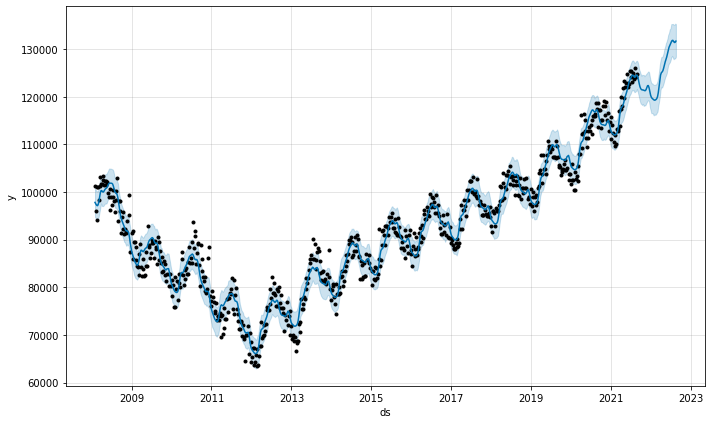

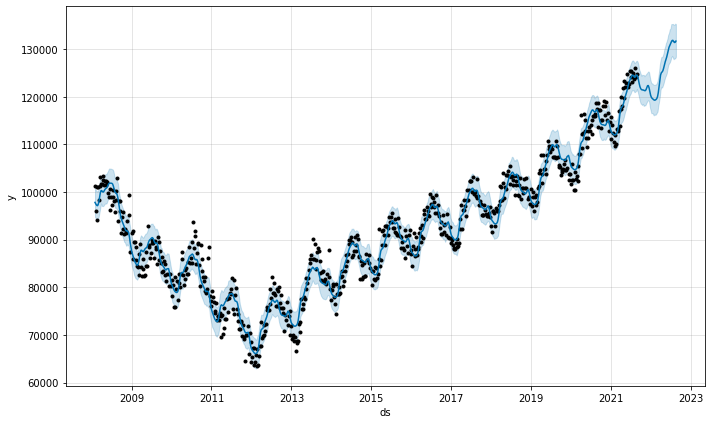

In [38]:
model.plot(prediction)

In [39]:
prediction_df = prediction[['ds','yhat']].tail(52)

#### Calculating RMSE & R2

In [40]:
fbprophet_mse = metrics.mean_squared_error(df['adj_price'][691:743], prediction_df['yhat'])
fbprophet_rmse = np.sqrt(fbprophet_mse)
fbprophet_r2 = metrics.r2_score(df['adj_price'][691:743], prediction_df['yhat'])
#from sklearn.metrics import mean_absolute_percentage_error
error_mape = mean_absolute_percentage_error(df['adj_price'][691:743],prediction_df['yhat'])



print("Results of fbprophet_metrics:")
print("RMSE:", fbprophet_rmse)
print("R-Squared:", fbprophet_r2)
print("MAPE:",error_mape)

Results of fbprophet_metrics:
RMSE: 5897.283469596595
R-Squared: -0.6045008177721822
MAPE: 0.04000026144145062


##### Based on the RMSE & R2 of both the models, we get that ARIMA model predictions are better than fbprophet model. Hence, we will use ARIMA model for prediction

## Final Prediction from BOTH models

In [41]:
from pandas.tseries.offsets import DateOffset
df['Week'] = pd.to_datetime(df['Week'],format='%m/%d/%Y')
future_dates = []
future_dates.append(df["Week"].iloc[-1])

for i in range(0,52):
  future_dates.append(future_dates[-1] + pd.offsets.Week())

In [42]:
future_dataset_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_dataset_df.tail()

,interest,vacancy,cpi,price,value,adj_price,adj_value,Week,Seasonal First Difference,forecast
2023-08-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
future_dataset_df.shape

(52, 10)

### Final **ARIMA** Prediction

In [44]:
model=sm.tsa.statespace.SARIMAX(df['adj_price'],order=(1, 1, 2),seasonal_order=(1,1,2,52))
results=model.fit()

In [45]:
predicted_values = results.predict(start = 743, end = 794, dynamic= True)
future_dataset_df['forecast_ARIMA'] = predicted_values.values

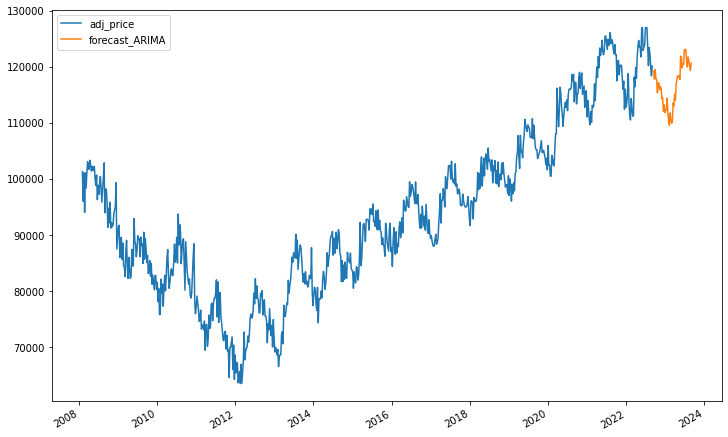

In [46]:
df["forecast_ARIMA"] = None
future_df=pd.concat([df,future_dataset_df])
future_df[['adj_price', 'forecast_ARIMA']].plot(figsize=(12, 8))

In [47]:
future_df['forecast_ARIMA'].tail(52)

2022-09-10    119217.754688
2022-09-17    119174.511783
2022-09-24    117809.671004
2022-10-01    119518.127615
2022-10-08    117929.973756
2022-10-15    117603.622835
2022-10-22    115367.849806
2022-10-29    117072.509029
2022-11-05    117141.069642
2022-11-12    115907.099803
2022-11-19    116437.316853
2022-11-26    116170.641064
2022-12-03    114314.121276
2022-12-10    114512.646575
2022-12-17    112075.697352
2022-12-24    113216.860301
2022-12-31    111841.056106
2023-01-07    112207.309014
2023-01-14    112410.941852
2023-01-21    114406.404203
2023-01-28    111774.850011
2023-02-04    110192.049611
2023-02-11    109569.561738
2023-02-18    111803.688353
2023-02-25    110514.734269
2023-03-04    109949.306140
2023-03-11    110177.690270
2023-03-18    113556.019553
2023-03-25    112986.631882
2023-04-01    115140.591822
2023-04-08    114008.163437
2023-04-15    116959.245824
2023-04-22    117632.446481
2023-04-29    118411.399561
2023-05-06    118219.760739
2023-05-13    118357

Final fbprophet Prediction

In [48]:
df_for_fbprophet = df[['Week','adj_price']]
df_for_fbprophet.head()

,Week,adj_price
Date,,
2008-02-02,2008-02-02,101331.92570
2008-02-09,2008-02-09,96033.13790
2008-02-16,2008-02-16,101087.51360
2008-02-23,2008-02-23,94034.89635
2008-03-01,2008-03-01,101087.51360


In [49]:
df_for_fbprophet['Week'] = pd.to_datetime(df_for_fbprophet['Week'],format='%m/%d/%Y')
df_for_fbprophet.columns = ['ds','y']
df_for_fbprophet.head(10)

,ds,y
Date,,
2008-02-02,2008-02-02,101331.92570
2008-02-09,2008-02-09,96033.13790
2008-02-16,2008-02-16,101087.51360
2008-02-23,2008-02-23,94034.89635
2008-03-01,2008-03-01,101087.51360
2008-03-08,2008-03-08,98384.61827
2008-03-15,2008-03-15,101195.60740
2008-03-22,2008-03-22,103069.60010
2008-03-29,2008-03-29,101734.38030


In [50]:
df_for_fbprophet.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [51]:
# Initialize the Model
model=Prophet()
# Fitting the Model
model.fit(df_for_fbprophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [52]:
model.component_modes

{'additive': ['yearly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [53]:
future_dates=model.make_future_dataframe(periods=52, freq="w")

In [54]:
future_dates

,ds
0,2008-02-02
1,2008-02-09
2,2008-02-16
3,2008-02-23
4,2008-03-01
...,...
790,2023-07-30
791,2023-08-06
792,2023-08-13
793,2023-08-20


In [55]:
future_dates.tail(52)

,ds
743,2022-09-04
744,2022-09-11
745,2022-09-18
746,2022-09-25
747,2022-10-02
748,2022-10-09
749,2022-10-16
750,2022-10-23
751,2022-10-30
752,2022-11-06


In [56]:
prediction=model.predict(future_dates)
prediction.head(52)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-02-02,101870.170039,93585.781553,100175.907216,101870.170039,101870.170039,-4968.905667,-4968.905667,-4968.905667,-4968.905667,-4968.905667,-4968.905667,0.0,0.0,0.0,96901.264372
1,2008-02-09,101658.512988,93311.739576,100219.542152,101658.512988,101658.512988,-5067.203003,-5067.203003,-5067.203003,-5067.203003,-5067.203003,-5067.203003,0.0,0.0,0.0,96591.309985
2,2008-02-16,101446.855936,93024.149474,99609.973120,101446.855936,101446.855936,-5109.694425,-5109.694425,-5109.694425,-5109.694425,-5109.694425,-5109.694425,0.0,0.0,0.0,96337.161511
3,2008-02-23,101235.198885,93058.908252,99452.719173,101235.198885,101235.198885,-5059.747143,-5059.747143,-5059.747143,-5059.747143,-5059.747143,-5059.747143,0.0,0.0,0.0,96175.451742
4,2008-03-01,101023.541833,93088.699506,99549.648387,101023.541833,101023.541833,-4679.906706,-4679.906706,-4679.906706,-4679.906706,-4679.906706,-4679.906706,0.0,0.0,0.0,96343.635127
5,2008-03-08,100811.884782,93620.880162,100373.638169,100811.884782,100811.884782,-3768.125356,-3768.125356,-3768.125356,-3768.125356,-3768.125356,-3768.125356,0.0,0.0,0.0,97043.759426
6,2008-03-15,100600.227730,94631.876781,101568.621150,100600.227730,100600.227730,-2471.122854,-2471.122854,-2471.122854,-2471.122854,-2471.122854,-2471.122854,0.0,0.0,0.0,98129.104876
7,2008-03-22,100388.570679,95494.150367,102387.391498,100388.570679,100388.570679,-1263.969555,-1263.969555,-1263.969555,-1263.969555,-1263.969555,-1263.969555,0.0,0.0,0.0,99124.601124
8,2008-03-29,100176.913627,96338.755963,103232.291418,100176.913627,100176.913627,-552.103128,-552.103128,-552.103128,-552.103128,-552.103128,-552.103128,0.0,0.0,0.0,99624.810500
9,2008-04-05,99965.256576,96402.400889,102917.439179,99965.256576,99965.256576,-313.524997,-313.524997,-313.524997,-313.524997,-313.524997,-313.524997,0.0,0.0,0.0,99651.731579


In [57]:
prediction.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

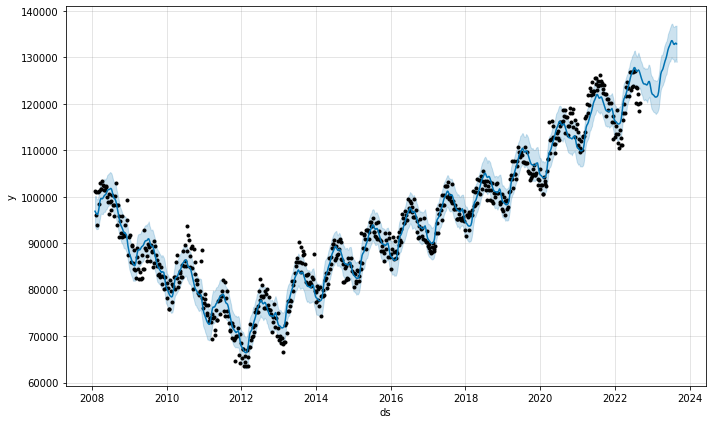

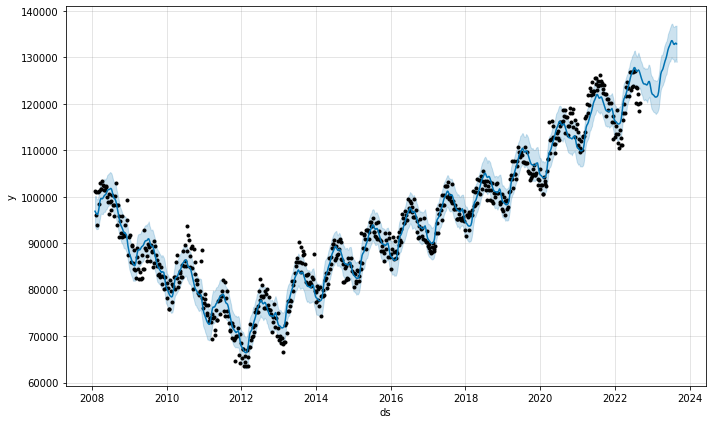

In [58]:
model.plot(prediction)

In [59]:
prediction[['ds','yhat']].tail(52)

,ds,yhat
743,2022-09-04,126566.927801
744,2022-09-11,126013.212147
745,2022-09-18,125502.877119
746,2022-09-25,125028.426422
747,2022-10-02,124612.843875
748,2022-10-09,124353.175299
749,2022-10-16,124288.115438
750,2022-10-23,124297.062344
751,2022-10-30,124222.712935
752,2022-11-06,124090.871974


In [60]:
prediction_df = prediction[['ds','yhat']].tail(52)

#prediction_df.to_csv('/content/drive/MyDrive/ProphetPrediction.csv',index=False)


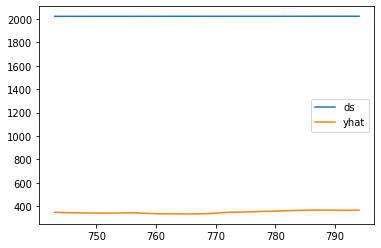

In [61]:
prediction_df.plot()

In [62]:
future_df['forecast_fbprophet'] = None
future_df['forecast_fbprophet'].iloc[743:795] = prediction_df['yhat']

Final Prediction by **Both** models

In [63]:
new_file = future_df[['forecast_ARIMA','forecast_fbprophet']].tail(52)
new_file

,forecast_ARIMA,forecast_fbprophet
2022-09-10,119217.754688,126566.927801
2022-09-17,119174.511783,126013.212147
2022-09-24,117809.671004,125502.877119
2022-10-01,119518.127615,125028.426422
2022-10-08,117929.973756,124612.843875
2022-10-15,117603.622835,124353.175299
2022-10-22,115367.849806,124288.115438
2022-10-29,117072.509029,124297.062344
2022-11-05,117141.069642,124222.712935
2022-11-12,115907.099803,124090.871974


In [64]:
new_file.to_csv('/content/drive/MyDrive/ProphetPrediction_newfile.csv',index=False)

Which month is best for real estate investment for the next 6-12 months?

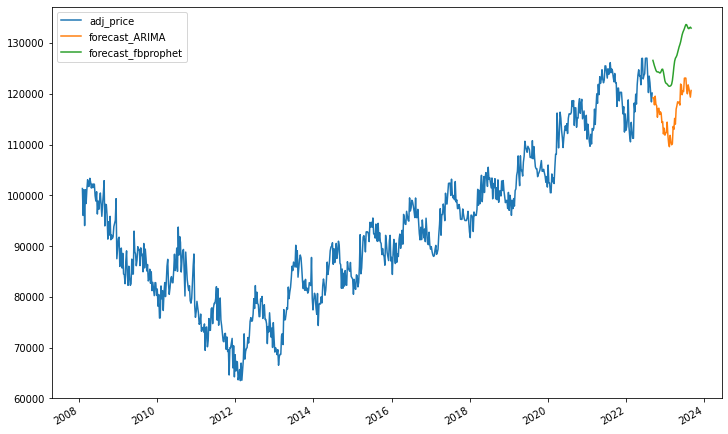

In [65]:
future_df[['adj_price', 'forecast_ARIMA','forecast_fbprophet']].plot(figsize=(12, 8))

Which month is best for real estate investment for the next 6-12 months?

In [66]:
#Based on ARIMA model prediction

future_df[future_df['forecast_ARIMA']==min(future_df['forecast_ARIMA'].tail(52))][['forecast_ARIMA']]

,forecast_ARIMA
2023-02-11,109569.561738


In [67]:
future_df[future_df['forecast_ARIMA']==max(future_df['forecast_ARIMA'].tail(52))][['forecast_ARIMA']]

,forecast_ARIMA
2023-07-08,123106.883629


In [68]:
#Based on fbprophet model prediction

future_df[future_df['forecast_fbprophet']==min(future_df['forecast_fbprophet'].tail(52))][['forecast_fbprophet']]

,forecast_fbprophet
2023-02-11,121465.077364


In [69]:
#Based on fbprophet model prediction

future_df[future_df['forecast_fbprophet']==max(future_df['forecast_fbprophet'].tail(52))][['forecast_fbprophet']]

,forecast_fbprophet
2023-07-15,133616.772754
